### This notebook will be mainly used for the capstone project

In [159]:
import pandas as pd
import numpy as np

In [160]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Solving environment: done

# All requested packages already installed.



# Part 1

scrape wikipedia page for data on Toronto neighborhoods and put into dataframe

In [161]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
table = pd.read_html(url)
df = table[0]

only process cells that have an assigned borough

In [162]:
df = df[df.Borough != "Not assigned"]
df.reset_index(drop=True, inplace=True)

In [163]:
df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


combine rows with the same postcode

In [164]:
df = df.groupby("Postcode").agg(lambda x : ', '.join(set(x)))
df.head()

,Borough,Neighbourhood
Postcode,,
M1B,Scarborough,"Malvern, Rouge"
M1C,Scarborough,"Rouge Hill, Highland Creek, Port Union"
M1E,Scarborough,"Morningside, Guildwood, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


if a row has a borough and an unassigned neighborhood, make the neighborhood value the same as the borough, because we already removed all unassigned boroughs, I can just look for unassigned neighborhoods

In [165]:
df.loc[df['Neighbourhood'] == "Not assigned",'Neighbourhood'] = df.loc[df['Neighbourhood'] == "Not assigned",'Borough']

In [166]:
df.shape

(103, 2)

# Part 2

read in csv from link and put into a dataframe

In [167]:
df1 = pd.read_csv('http://cocl.us/Geospatial_data')

change df1 column name to match df and merge them

In [168]:
df1.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
df = pd.merge(df, df1, on='Postcode', how = 'left')

In [169]:
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Highland Creek, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Morningside, Guildwood, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Part 3

Slice original dataframe and create new one with only data for Boroughs that contain "Toronto"

In [170]:
df1 = df[df['Borough'].str.contains('Toronto')]
df1.reset_index(drop=True, inplace=True)
df1.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [171]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


In [172]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df1['Latitude'], df1['Longitude'], df1['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

#### Define Foursquare Credentials and Version (Hidden Cell)

In [199]:
# The code was removed by Watson Studio for sharing.

#### Explore the first neighborhood in our dataframe.

In [174]:
df1.loc[0, 'Neighbourhood']

'The Beaches'

In [175]:
neighborhood_latitude = df1.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df1.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df1.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


#### Get the top 100 venues that are in The Beaches within a radius of 500 meters.

In [176]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=QROVKUGRXDMAMEXYRU4FZKN3XI1UUNWKLFWAFHHZ10TXAIKT&client_secret=HNPLIWDCXVYD214TBG0GOL533C22XDZT4FAEJUIPOHNP0XW4&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

In [177]:
results = requests.get(url).json()

In [178]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [179]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869


In [180]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


#### Explore Neighborhoods in Toronto

In [181]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [182]:
toronto_venues = getNearbyVenues(names=df1['Neighbourhood'],
                                   latitudes=df1['Latitude'],
                                   longitudes=df1['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, Forest Hill SE, South Hill, Deer Park
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, Richmond, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
North Midtown, The Annex, Yorkville
Harbord, University of Toronto
Chinatown, Kensington Market, Grange Park
CN Tower, Harbourfront West, Island airport, Bathurst Quay, King and Spadina, South Niagara, Railway Lands
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Trinity, Little Portugal
Exhibition Place, Brockton, Parkdale Village
The Junction So

In [183]:
print(toronto_venues.shape)
toronto_venues.head()

(1697, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


#### Analyze Each Neighborhood

In [184]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
toronto_onehot.shape

(1697, 232)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [198]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide, Richmond, King",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.040000,0.0,...,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.01,0.0,0.000000
1,Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.00,0.0,0.000000
2,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.052632
3,"CN Tower, Harbourfront West, Island airport, B...",0.0,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000
4,"Cabbagetown, St. James Town",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.023256,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000


First, let's write a function to sort the venues in descending order.

In [187]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [188]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, Richmond, King",Coffee Shop,Café,Thai Restaurant,American Restaurant,Bar,Steakhouse,Cosmetics Shop,Restaurant,Gym,Sushi Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Steakhouse,Seafood Restaurant,Farmers Market,Café,Beer Bar,Park
2,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Spa,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Recording Studio
3,"CN Tower, Harbourfront West, Island airport, B...",Airport Service,Airport Lounge,Airport Terminal,Plane,Harbor / Marina,Coffee Shop,Sculpture Garden,Boat or Ferry,Boutique,Airport Food Court
4,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Café,Italian Restaurant,Bakery,Pub,Pizza Place,Pet Store,Sandwich Place,Butcher


#### 4. Cluster Neighborhoods
Run *k*-means to cluster the neighborhood into 5 clusters.

In [189]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [190]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [191]:
toronto_merged = df1

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Neighborhood,Health Food Store,Trail,Pub,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Yoga Studio,Pizza Place,Bookstore,Brewery,Bubble Tea Shop
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Brewery,Steakhouse,Sushi Restaurant,Italian Restaurant,Movie Theater,Pub,Ice Cream Shop,Fish & Chips Shop,Sandwich Place,Fast Food Restaurant
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Bakery,Gastropub,Italian Restaurant,American Restaurant,Bar,Stationery Store,Clothing Store,Middle Eastern Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Gym / Fitness Center,Park,Bus Line,Swim School,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [192]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

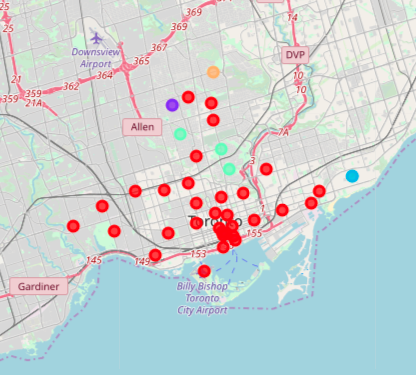

### Cluster 0 generally have a coffee shops as their most common venue

In [193]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,East Toronto,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Ice Cream Shop,Yoga Studio,Pizza Place,Bookstore,Brewery,Bubble Tea Shop
2,East Toronto,0,Brewery,Steakhouse,Sushi Restaurant,Italian Restaurant,Movie Theater,Pub,Ice Cream Shop,Fish & Chips Shop,Sandwich Place,Fast Food Restaurant
3,East Toronto,0,Café,Coffee Shop,Bakery,Gastropub,Italian Restaurant,American Restaurant,Bar,Stationery Store,Clothing Store,Middle Eastern Restaurant
5,Central Toronto,0,Breakfast Spot,Clothing Store,Sandwich Place,Park,Gym,Hotel,Food & Drink Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant
6,Central Toronto,0,Sporting Goods Shop,Coffee Shop,Clothing Store,Yoga Studio,Chinese Restaurant,Park,Fast Food Restaurant,Spa,Mexican Restaurant,Salon / Barbershop
7,Central Toronto,0,Pizza Place,Sandwich Place,Dessert Shop,Café,Italian Restaurant,Coffee Shop,Sushi Restaurant,Pharmacy,Indian Restaurant,Seafood Restaurant
9,Central Toronto,0,Coffee Shop,Pub,Fried Chicken Joint,Sushi Restaurant,Bagel Shop,Restaurant,Sports Bar,American Restaurant,Supermarket,Pizza Place
11,Downtown Toronto,0,Coffee Shop,Restaurant,Café,Italian Restaurant,Bakery,Pub,Pizza Place,Pet Store,Sandwich Place,Butcher
12,Downtown Toronto,0,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Gym,Mediterranean Restaurant,Bubble Tea Shop,Gastropub,Fast Food Restaurant
13,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Mexican Restaurant,Café,Restaurant,Theater,Gym / Fitness Center


### Cluster 1 has a garden as their most common venue

In [194]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,1,Garden,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


### Cluster 2 has a neighborhood as their most common venue

In [195]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,2,Neighborhood,Health Food Store,Trail,Pub,Dumpling Restaurant,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop


### Cluster 3 has parks/playgrounds as their most common venue

In [196]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,3,Playground,Gym,Park,Trail,Yoga Studio,Dumpling Restaurant,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
10,Downtown Toronto,3,Park,Playground,Trail,Building,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
23,Central Toronto,3,Park,Trail,Sushi Restaurant,Jewelry Store,Yoga Studio,Dive Bar,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


### Cluster 4 has a gym as their most common venue

In [197]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,4,Gym / Fitness Center,Park,Bus Line,Swim School,Yoga Studio,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
